In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import cv2
from IPython.display import display
import time

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
tf.gfile = tf.io.gfile

from tensorflow.keras.models import model_from_json

%run ../utils/object_detection_utils.ipynb
%run ../utils/image_utils.ipynb
%run ../utils/data_utils.ipynb

ROOT = "/mnt/nvme-storage/pfauregi"

# Detection

In [3]:
detection_model_path = os.path.join(ROOT,"training/obj_detection/ws_bd/models/model/export/saved_model/")
labels_path = os.path.join(ROOT,"artificial_datasets/dataset01_tfr/binary_label_map.pbtxt")

In [4]:
def run_detection(model_path, sample):
    start = time.time()
    model = tf.saved_model.load(model_path)
    model = model.signatures['serving_default']
    detection_results = run_inference_for_single_image(model, sample)
    print("Detection processed in", time.time()-start, "s!")
    return detection_results

def get_thumbails_batch(sample, detection, score_thresold=0.5, verbose=False):
    thumbails = {}
    thumbails["batch"] = []
    thumbails["bounding_box"] = []
    thumbails["score"] = []
    image_detections = sample.copy()
    height, width, channels = image_detections.shape
    for box, score in zip(detection['detection_boxes'], detection['detection_scores']):
        if score>score_thresold:
            ymin, xmin, ymax, xmax = int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)
            if verbose: image_detections = cv2.rectangle(image_detections, (xmin, ymin), (xmax, ymax), (255, 0, 0), 4)
            thumbail = sample[ymin:ymax, xmin:xmax, :]
            thumbail = convert_to_square(thumbail, new_size=256)
            thumbails["batch"].append(thumbail)
            thumbails["bounding_box"].append([ymin, xmin, ymax, xmax])
            thumbails["score"].append(score)
    thumbails["batch"] = np.array(thumbails["batch"]).astype('float32')/255
    if verbose: 
        display(Image.fromarray(image_detections).resize((int(0.2*width), int(0.2*height))))
        display(Image.fromarray((thumbails["batch"][2]*255).astype('uint8')))
        thumbails["batch"][1].shape[0]
    return thumbails

# Classification

In [5]:
class_root = "/home/pfauregi/Super-Diatomee-Classifier/diatom_classification/thumbnail_classification/saved_models/"
class_model_path = os.path.join(class_root, "model.json")
class_model_weights = os.path.join(class_root, "model.h5")

inv_id_map = {v: k for k, v in get_selected_taxons('../selected_taxons.txt').items()} 

In [56]:
def run_classification(class_model_path, class_model_weights, thumbails_batch):
    json_file = open(class_model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(class_model_weights)
    loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    out = loaded_model.predict(thumbails_batch, batch_size=thumbails_batch.shape[0], use_multiprocessing=True)
    return out

def draw_classif(sample, thumbails, image_scale = 0.4, text_scale = 1):
    image_detections = sample.copy()
    for bb, label, score in zip(thumbails["bounding_box"], thumbails["labels"], thumbails["score"]):
        if np.max(label)>=0.4:
            if np.max(label) < 0.4:
                label_text = "not sure"
            else:
                label_text = inv_id_map[np.argmax(label)]

            color = (255, 0, 0)
            font = cv2.FONT_HERSHEY_SIMPLEX
            ymin, xmin, ymax, xmax = bb
            cv2.rectangle(image_detections, (xmin, ymin), (xmax, ymax), color, 4)
            cv2.putText(image_detections,  label_text, (xmin, ymin+80), font, text_scale*3, color, 4, cv2.LINE_AA) 
            cv2.putText(image_detections,  "Detect: "+str(score), (xmin+5, ymin+120), font, text_scale*1, color, 2, cv2.LINE_AA) 
            cv2.putText(image_detections,  "Classif: "+str(np.max(label)), (xmin+5, ymin+160), font, text_scale*1, color, 2, cv2.LINE_AA) 
    height, width, channels = image_detections.shape
    display(Image.fromarray(image_detections).resize((int(image_scale*width), int(image_scale*height))))
    cv2.imwrite("./test.png", image_detections)

# Full pipeline

In [49]:
#path = os.path.join(ROOT,"datasets/micro_samples/")
path = "/mnt/nvme-storage/pfauregi/artificial_datasets/dataset03/images"
onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Detection processed in 5.96363639831543 s!


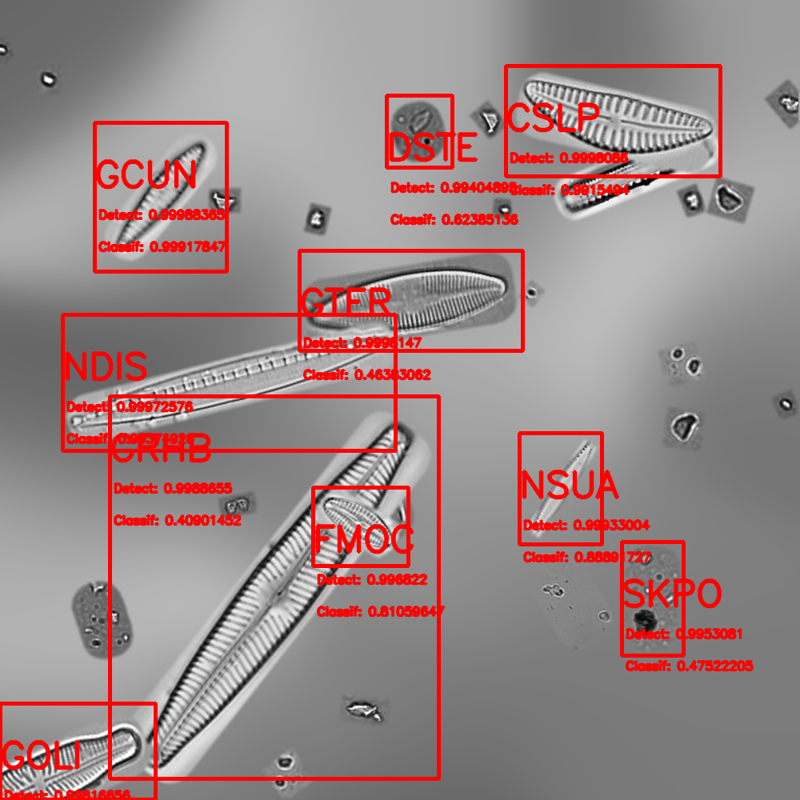

In [57]:
sample = load_image(os.path.join(path, onlyfiles[3]))
#display(Image.fromarray(sample))

# Detection
detection_results = run_detection(detection_model_path, sample)
thumbails = get_thumbails_batch(sample, detection_results, score_thresold=0.99, verbose=False)

# Classification
thumbails["labels"] = run_classification(class_model_path, class_model_weights, thumbails["batch"])
draw_classif(sample, thumbails, image_scale=0.8, text_scale=0.5)

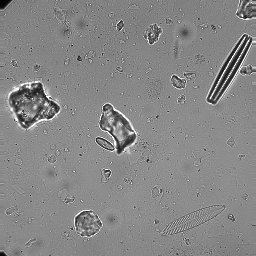

In [11]:
display(Image.fromarray((thumbails["batch"][5]*255).astype('uint8')))